# 3. Reconstruct using inverse Abel transform

In this notebook, we will use absorbance and inverse Abel transform to compute the concentration field assuming axial symmetry.

First, we should have run the following notebooks:
- `1 Preprocessing` to extract and denoise absorbance data.
- `2 Integrate` to measure the mass (minus probe shadow).

First we import Python modules and define some paraemters.

In [1]:
# Python imports
import numpy as np

from skimage.transform import rotate

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.optimize import curve_fit

from abel.basex import basex_transform

In [2]:
# Hyper parameters

# pixels per cm
pxpcm = 367

# Time step between images (min)
dt = 1.

# Molar extinction coefficient (cm^-1 L/mol)
epsilon = 2900.

# Methylene blue molar mass (g mol^-1)
M = 319.85

## Import fields

In [3]:
A = np.load('absorbance.npy')
mask = np.load('mask.npy')
print(f"Time steps (including time 0): {A.shape[0]}")
print(f"Image dimensions (height, width): {A.shape[1:]}")

Time steps (including time 0): 1020
Image dimensions (height, width): (1039, 355)


## Rotate & find symmetry axis

Use `i_min` and `i_max` as relative min and max lines to consider for finding the symmetry axis.

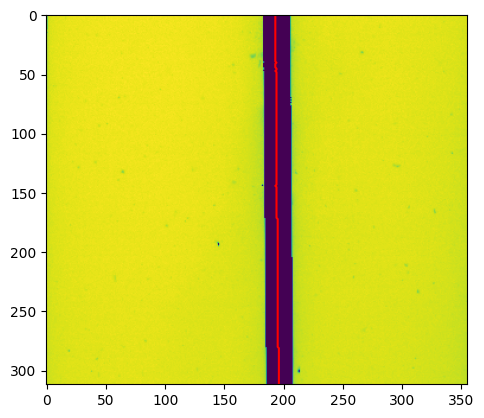

In [4]:
i_min = 0.4
i_max = 0.7

centres = []
ref = mask.copy()
ref[np.isnan(ref)] = 0
height, width = ref.shape
for i, line in enumerate(ref[int(i_min*height):int(i_max*height)]):
    line_hat = np.fft.rfft(line)
    conv = np.fft.irfft(line_hat**2)
    j = np.argmax(conv)
    if j<width//2:
        centres.append(width//2 + np.argmax(conv)//2)
    else:
        centres.append(np.argmax(conv)//2+1)
    
plt.imshow(ref[int(i_min*height):int(i_max*height)])
plt.plot(centres, list(range(len(centres))), 'r')
plt.show()

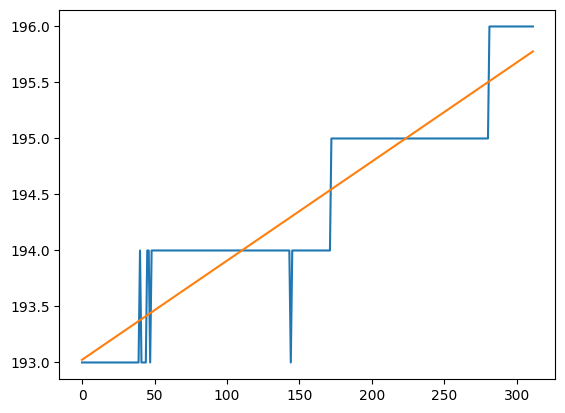

In [5]:
# Fit slope with linear function
y = np.arange(len(centres))
[a,b], pcov = curve_fit(lambda y,a,b: a*y+b,y,centres)

plt.plot(centres)
plt.plot(a*y+b)
plt.show()
    

A new rotated mask is calculated. Because of interpolation, we must reapply the threshold. Threshold is given by `min_intensity_gen`.

Rotation angle: -0.507 degrees


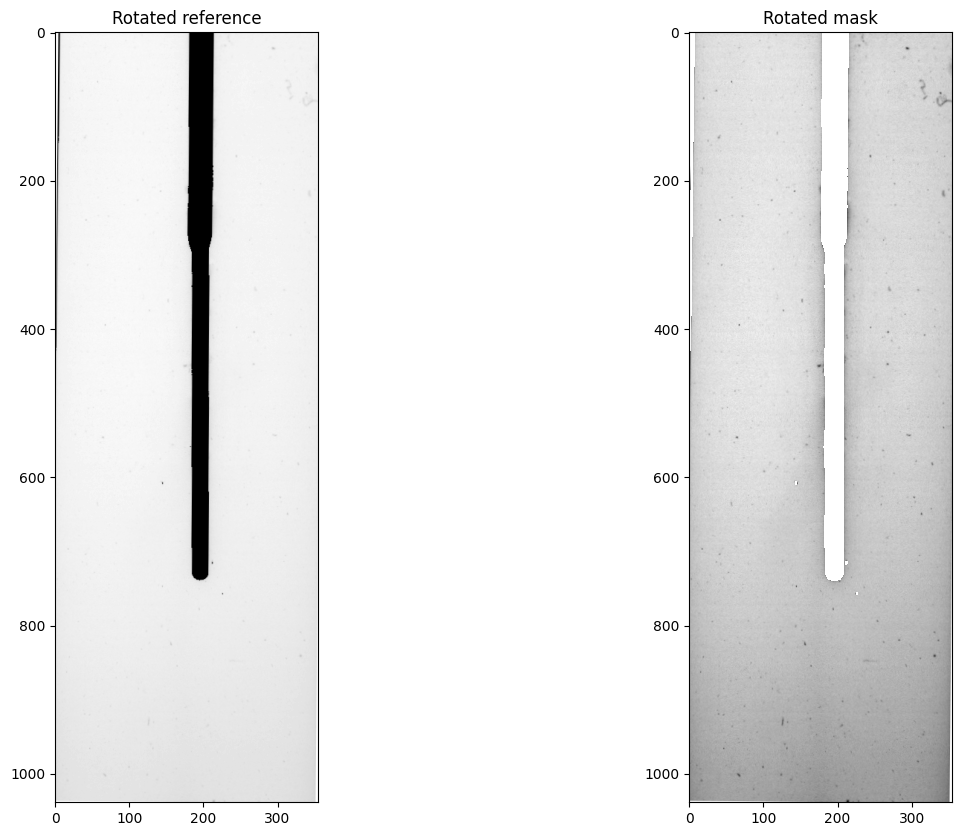

In [6]:
# Calculate angle, rotate reference image and threshold again to create new mask
angle = np.arctan(a)
print(f'Rotation angle: {-angle*180/np.pi:.3f} degrees')

ref_rot = rotate(ref, -angle*180/np.pi, resize=False, mode='constant', order=1, cval=1.)
mask_rot = ref_rot.copy()

min_intensity_gen = 0.7

mask_rot[mask_rot<min_intensity_gen] = np.nan
np.save('mask_rot', mask_rot)

plt.rcParams["figure.figsize"] = (15,10)
figure, ax = plt.subplots(ncols=2)
        
ax[0].imshow(ref_rot, cmap='gray')
ax[0].set_title('Rotated reference')

ax[1].imshow(mask_rot, cmap='gray')
ax[1].set_title('Rotated mask')

plt.show()
    

Because the image has been rotated, we must recalculate the position of the symmetry axis (now a single number).

Identified axis column: 193


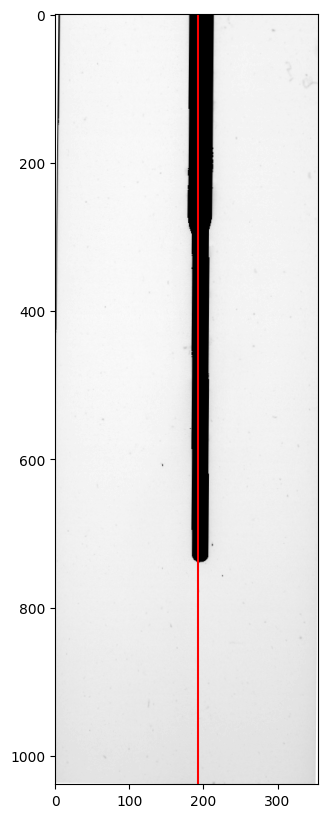

In [7]:
centres = []

for i, line in enumerate(ref_rot[int(i_min*height):int(i_max*height)]):
    line_hat = np.fft.rfft(line)
    conv = np.fft.irfft(line_hat**2)
    j = np.argmax(conv)
    if j<width//2:
        centres.append(width//2 + np.argmax(conv)//2)
    else:
        centres.append(np.argmax(conv)//2)

axis = int(np.average(centres))   
print("Identified axis column:", axis)
plt.imshow(ref_rot, cmap='gray')
plt.plot([axis,axis], [0, len(ref_rot)-1],'r')
plt.show()

In [8]:
# Now rorate all absorbance images
A_rot = np.empty_like(A)
for i, im in tqdm(enumerate(A), total=len(A)):
    A_rot[i] = rotate(im, -angle*180/np.pi, resize=False, mode='constant', order=1, cval=0.)

  0%|          | 0/1020 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/skimage/transform/_warps.py:738: RuntimeWarning: All-NaN slice encountered
  min_val = min_func(input_image)
/opt/homebrew/lib/python3.11/site-packages/skimage/transform/_warps.py:742: RuntimeWarning: All-NaN slice encountered
  max_val = max_func(input_image)
100%|██████████| 1020/1020 [00:03<00:00, 307.53it/s]


## Concentration field reconstruction using inverse Abel transform

By convention, the inverse Abel transform considers the first column (left) as the symmetry axis, see https://pyabel.readthedocs.io/en/latest/abel.html#module-abel.basex. Therefore we split the image in two parts and include the axis in both:

In [9]:
A_right = A_rot[:,:,axis:]
A_left = A_rot[:,:,:axis+1]

We are going to test the inverse Abel on one image first, selected at time `t`. 

We need to specify the size of the base functions, `sigma` (in pixels). If the absorbance image is already well smooth, then a small value (1) is ok. For noisy images, values larger than 1 can be used.

In [10]:
# Select absorbance image
t = 60

# Select base size
sigma = 1

# The result is in µg/mL

c_right = pxpcm*M*1e3/epsilon*basex_transform(A_right[t], sigma=sigma)
c_left = pxpcm*M*1e3/epsilon*basex_transform(np.flip(A_left[t], axis=1), sigma=sigma)
c = np.hstack((np.flip(c_left, axis=1),c_right[:,1:]))
c[np.isnan(mask_rot)] = np.nan

A suitable basis set was not found.
A new basis set will be generated.
This may take a few minutes.
But don't worry, it will be saved to disk for future use.
Generating horizontal BASEX basis sets for n = 162, sigma = 1.0 (nbf = 162):
k = 0...50...100...150...162
Basis set saved for later use to
  basex_basis_162_1.0.npy
Updating regularization...
Calculating correction...
A suitable basis set was not found.
A new basis set will be generated.
This may take a few minutes.
But don't worry, it will be saved to disk for future use.
(extending basex_basis_162_1.0.npy)
Generating horizontal BASEX basis sets for n = 194, sigma = 1.0 (nbf = 194):
k = 0...50...100...150...194
Basis set saved for later use to
  basex_basis_194_1.0.npy
Updating regularization...
Calculating correction...


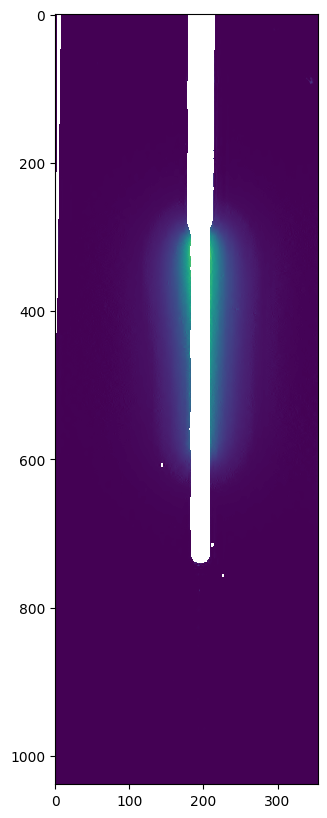

-233.480820314571 198.55133145908522


In [11]:
plt.rcParams["figure.figsize"] = (15,10)
plt.imshow(c, vmin=0, vmax=200)
plt.show()
print(np.nanmin(c), np.nanmax(c))

We should check artefacts like negative concentrations or high values near the edge.

### Mass from reconstructed concentration field

We can caluclate the total mass in the absorbance image, this time accounting for probe shadow. This is done by using the **forward** Abel transform on the previously calculated concentration field: this gives the absorbance we should see if there was a void instead of the probe. Then we sum the absorbance field as in previous notebook `2 Integrate`. Let's test it on one image first:

Loading basis sets...
Updating regularization...
Calculating correction...
Loading basis sets...
Updating regularization...
Calculating correction...


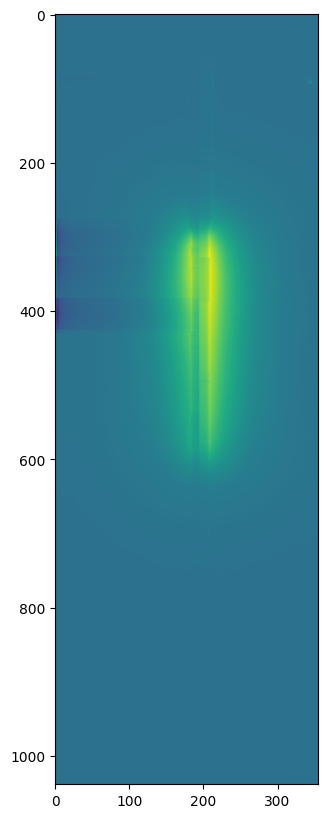

Total mass found (µg): 4.869883341185958


In [12]:
c[np.isnan(c)] = 0
c_right = c[:,axis:]
c_left = c[:,:axis+1]

# In pixel*µg/mL
B_right = basex_transform(c_right, sigma=sigma, direction='forward')
B_left = basex_transform(np.flip(c_left, axis=1), sigma=sigma, direction='forward')

B = np.hstack((np.flip(B_left, axis=1),B_right[:,1:]))
plt.imshow(B)
plt.show()

print('Total mass found (µg):', np.sum(B)/pxpcm**3)

If we are happy, let's do it for the whole stack!

In [13]:
c = np.empty_like(A)
mass_Abel = []
for t in tqdm(range(len(A_left))):
    
    c_right = pxpcm*M*1e3/epsilon*basex_transform(A_right[t], sigma=sigma, verbose=False)
    c_left = pxpcm*M*1e3/epsilon*basex_transform(np.flip(A_left[t], axis=1), sigma=sigma, verbose=False)
    c_temp = np.hstack((np.flip(c_left, axis=1),c_right[:,1:]))
    c_temp[np.isnan(mask_rot)] = 0
    c_temp[c_temp<0] = 0
    c[t] = c_temp
    
    # Compute total mass
    c_right = c_temp[:,axis:]
    c_left = c_temp[:,:axis+1]
    # In pixel*µg/mL
    B_right = basex_transform(c_right, sigma=sigma, direction='forward', verbose=False)
    B_left = basex_transform(np.flip(c_left, axis=1), sigma=sigma, direction='forward', verbose=False)
    B = np.hstack((np.flip(B_left, axis=1),B_right[:,1:]))
    
    # Either use all image:
    # m = np.sum(B)/pxpcm**3
    
    # Or just use forward Abel only to fill in shadow
    B2 = 1e3*M/epsilon*pxpcm*A_rot[t]
    B2[np.isnan(mask_rot)] = B[np.isnan(mask_rot)]
    m = np.sum(B2)/pxpcm**3
    
    mass_Abel.append(m)
mass_Abel = np.array(mass_Abel)
mass_Abel[0] = 0

100%|██████████| 1020/1020 [35:03<00:00,  2.06s/it]


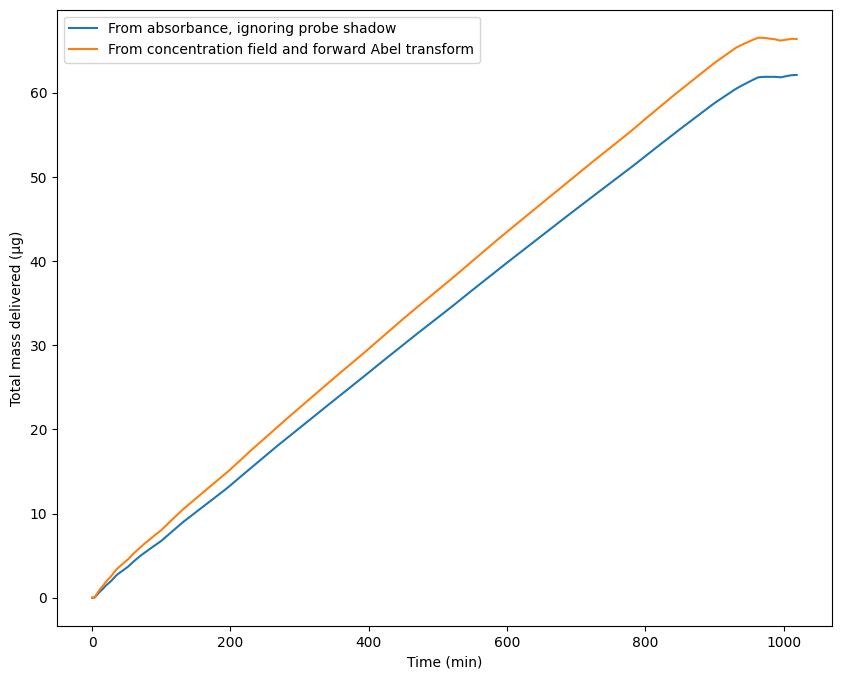

In [14]:
# Import previous data
previous_data = np.loadtxt('mass.txt')
time = previous_data[:,0]
mass = previous_data[:,1]
rate = previous_data[:,2]

plt.rcParams["figure.figsize"] = (10,8)
plt.plot(time, mass, label='From absorbance, ignoring probe shadow')
plt.plot(time, mass_Abel, label='From concentration field and forward Abel transform')
plt.ylabel('Total mass delivered (µg)')
plt.xlabel('Time (min)')
#plt.ylim(0,22)
plt.legend()
plt.show()

### Effect of probe shadow

/var/folders/2s/hbpk4wxn4c30ctdxk4bgqlnr0000gn/T/ipykernel_4526/1840552190.py:3: RuntimeWarning: invalid value encountered in divide
  rel_error = 1 - mass/mass_Abel


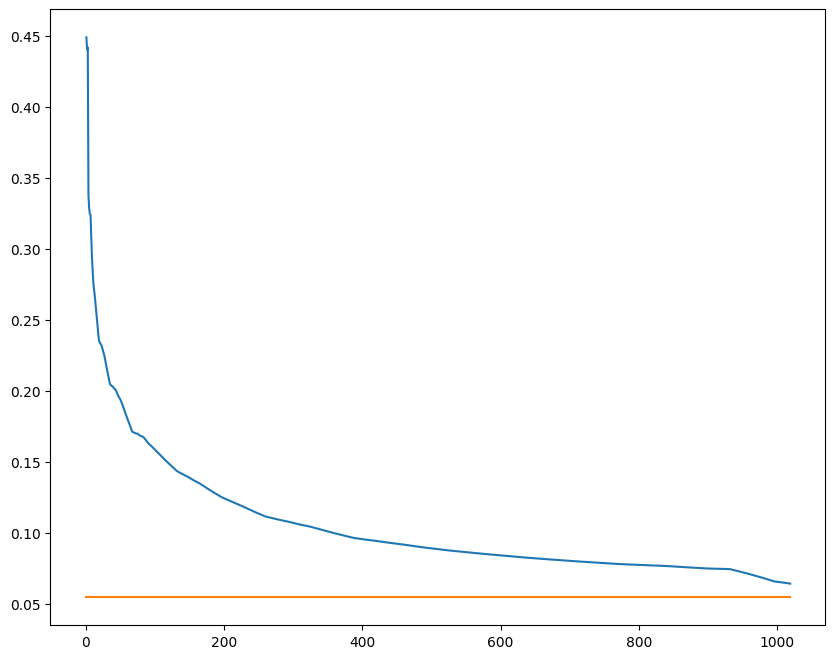

In [15]:
floor = np.sum(np.isnan(mask))/(height*width)

rel_error = 1 - mass/mass_Abel
plt.plot(time, rel_error, label='Relative error')
plt.plot([time[0], time[-1]], [floor, floor], label='Shadow')
plt.show()

### Delivery rates

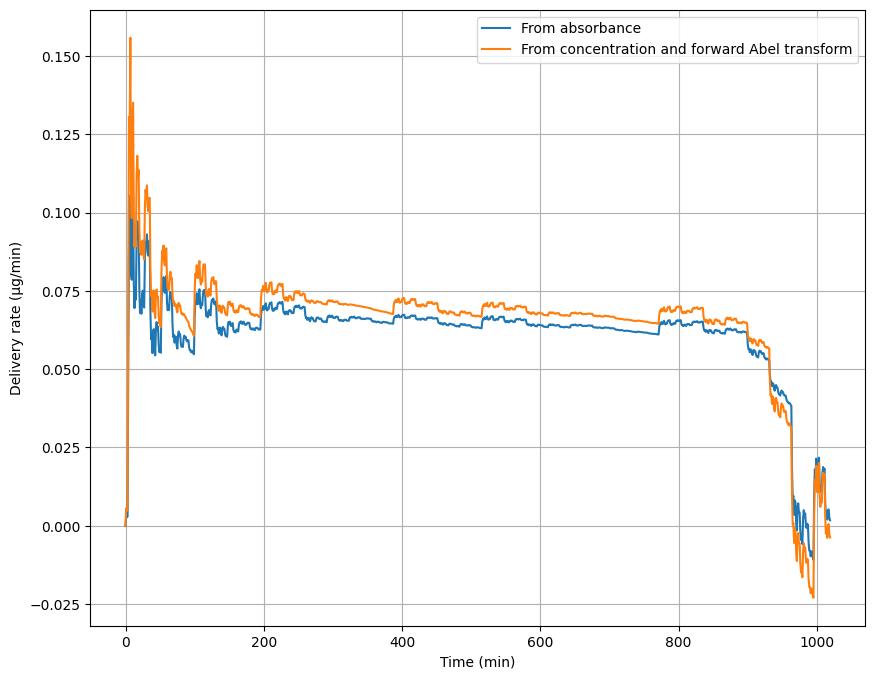

In [16]:
rate_Abel = np.empty_like(mass_Abel)
rate_Abel[0] = 0
rate_Abel[1:] = np.diff(mass_Abel)/dt

plt.plot(time, rate, label='From absorbance')
plt.plot(time, rate_Abel, label='From concentration and forward Abel transform')
plt.ylabel('Delivery rate (µg/min)')
plt.xlabel('Time (min)')
plt.legend()
plt.grid()
plt.show()

## Save data

In [17]:
mass_Abel[0] = 0
np.savetxt('mass_Abel.txt', np.hstack((time[:, None], mass_Abel[:, None], rate_Abel[:, None])), header='# time (min),  mass (ug), rate (ug/min)')

## Concentration map survey

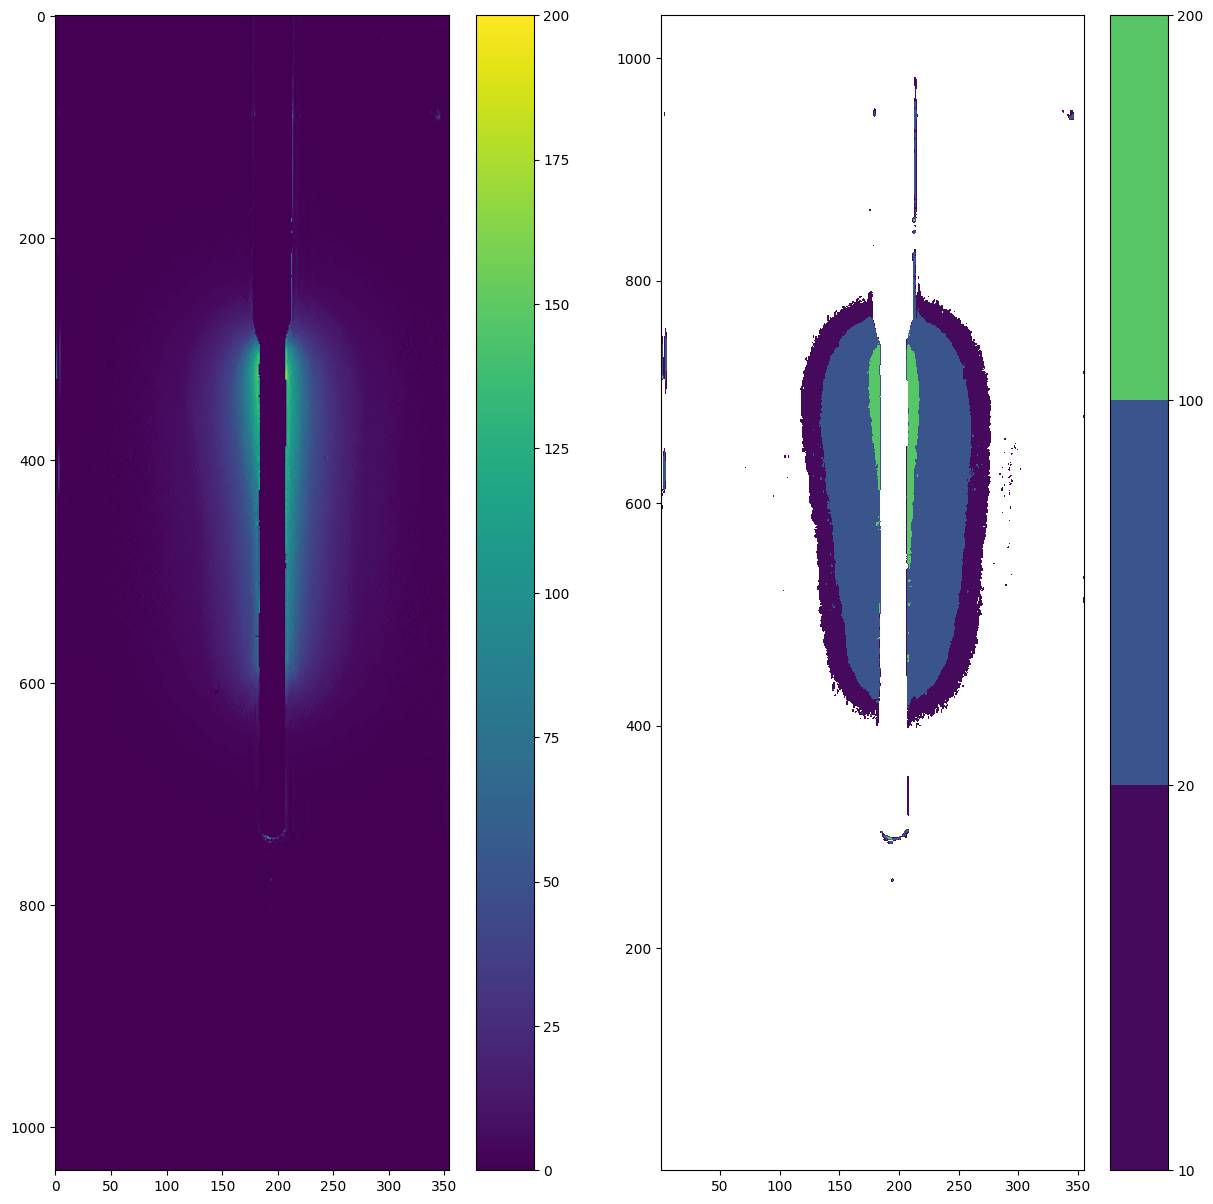

In [18]:
t = 60

plt.rcParams["figure.figsize"] = (15,15)
figure, ax = plt.subplots(ncols=2)

im = ax[0].imshow(c[t], vmin=0, vmax=200)
im.cmap.set_over('r')
figure.colorbar(im, ax=ax[0])
con = ax[1].contourf(c[t], [10, 20, 100, 200], origin='image')
figure.colorbar(con, ax=ax[1])
plt.show()

In [19]:
# Save concentration slice for later use
#np.save('c_20min', c[20])
#np.save('c_60min', c[60])
#np.save('c_120min', c[120])
#np.save('c_5ug', c[42])